
Imports e definição do dataset.

In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

Carregamento do dataset cifar-10

In [ ]:
# Carregar o conjunto de dados CIFAR-10
cifar10 = keras.datasets.cifar10
#Carrega duas tuplas, representando os dados de treinamento e de teste.
#Cada tupla tem as imagens e os respectivos rótulos
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
num_classes = 10

O código abaixo mostra as 10 primeiras imagens de treino e teste do cifar-10

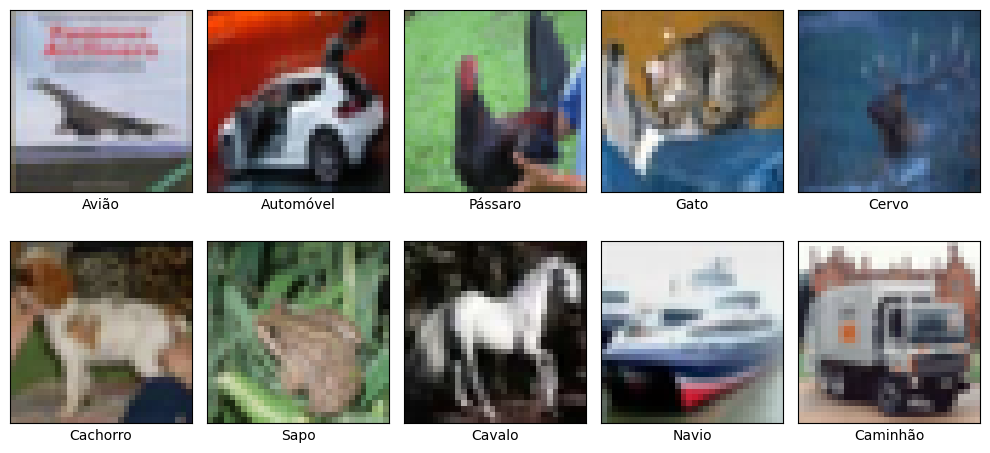

In [ ]:
# Defina as classes do CIFAR-10
class_names = ['Avião', 'Automóvel', 'Pássaro', 'Gato', 'Cervo',
               'Cachorro', 'Sapo', 'Cavalo', 'Navio', 'Caminhão']

# Crie um dicionário para mapear as classes para as imagens correspondentes
class_to_image = {}
for i in range(10):
    index = (test_labels == i).nonzero()[0][0]  # Encontre o primeiro índice da classe
    class_to_image[i] = test_images[index]

# Mostre uma imagem de cada classe
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.xticks([])  # Remova os rótulos do eixo x
    plt.yticks([])  # Remova os rótulos do eixo y
    plt.imshow(class_to_image[i])
    plt.xlabel(class_names[i])

plt.tight_layout()
plt.show()

Abaixo, convertemos os rótulos escalares (números de 0 a 9) para one-hot encoding.

Não é necessário realizar este passo, caso seja utilizada a função de custo esparse_categorical_cross_entropy

In [ ]:
# Converter para codificação one-hot dos labels
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=num_classes)
#Não é necessário se utilizar como função de custo esparse_categorical_cross_entropy

Função que retorna uma rede neural para o cifar-10

In [ ]:
# Crie o modelo de rede neural convolucional simples
def get_cifar10_network():
    model = keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),#(32, 32, 3) porque as imagens são 32X32 e RGB, portanto, tendo 3 canais de cor
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')  # 10 classes de saída
    ])

    # Compile o modelo
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',#pode ser substituída pela esparse_categorical_cross_entropy
                  metrics=['accuracy'])

    model.summary()

    return model

Trecho para treinar e avaliar a rede neural.
O treino é realizado com os dados de treino e a avaliação do modelo é realizada nos dados de teste.

In [ ]:
# Treine o modelo
model = get_cifar10_network()
model.fit(train_images, train_labels, epochs=10)

# Avalie o modelo no conjunto de teste
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f'Acurácia no conjunto de teste: {test_accuracy * 100:.2f}%')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 7200)              0         
                                                                 
 dense_6 (Dense)             (None, 64)                460864    
                                                                 
 dense_7 (Dense)             (None, 10)                650       
                                                                 
Total params: 462410 (1.76 MB)
Trainable params: 462410 (1.76 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

Na célula abaixo, adicione o código para carregar os demais datasets

In [ ]:
#Inclua o código para carregar os demais datasets

Tarefa
Escreva código para executar redes neurais nos seguintes datasets:

MNIST (pode aproveitar o codigo existente)
Fashion MNIST
CIFAR-10
CIFAR-100
Cada execução deve ser por 10 épocas.

Você deve preencher as funções a seguir para retornarem a rede neural com a melhor configuração que você conseguiu para cada dataset. O notebook deve ser entregue com a rede neural que obteve a melhor performance em cada conjunto de dados.

IMPORTANTE: as funções não devem TREINAR nem AVALIAR as redes neurais, apenas instanciá-las e retorná-las.

Ao final, preencha o dict results com o desempenho encontrado em cada execução.

In [ ]:
def get_fashion_mnist_network():
  pass  # substitua pelo seu codigo

def get_mnist_network():
  pass  # substitua pelo seu codigo

def get_cifar100_network():
  pass # substitua pelo seu codigo

#Você pode aproveitar as ideias do exemplo acima
def get_cifar10_network():
  pass # substitua pelo seu codigo

Preencha o dict abaixo substituindo os None com a acuracia final (acc) e o tempo de treinamento (time) encontrado no seu experimento pra cada dataset

In [ ]:
results = {
    "mnist": {"time": None, "acc": None},
    "fashion_mnist": {"time": None, "acc": None},
    "cifar10": {"time": None, "acc": None},
    "cifar100": {"time": None, "acc": None},
}